# Imports

In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import emcee
import corner
from multiprocessing import Pool, cpu_count

from minot.ClusterTools import map_tools
import pitszi

import time

# Parameters

In [2]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.8
euler_1, euler_2, euler_3 = 40*u.deg, 50*u.deg, 15*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 600*u.kpc
fluct_seed = 100

In [3]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(6*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_smoothing = 10*u.arcsec
mask_Nps = 0
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: 1e-9 + 3e-9 * (k_arcsec*60)**-1
noise_r = lambda r_arcsec: 1 + np.exp((r_arcsec-200)/80)
noise_seed = 1

In [4]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 40
scale_bins = 'linear'
kmin_pk = 1/(300)*u.arcsec**-1
kmax_pk = 1/beam_FWHM.to('arcsec')
pk_method = 'Naive' # 'Arevalo12', 'Naive'
img_method = 'subtract' # 'subtract', 'ratio'

# MCMC
nwalkers = 100
nsteps = 50
burnin = 20
mcmc_reset = False
mcmc_run = True
mcmc_output_profile = '/Users/adam/Desktop/pitszi_MCMC_profile_sampler.h5'

# Generate the mock data

In [5]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True)

mock.set_pressure_profile_universal_param('A10MD')

mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}

mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
        
mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5.0*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

print('')
print('----- Scale -----')
print('Pixel size in kpc: ', mock.get_map_reso(physical=True))
print('FoV in Mpc: ', mock.get_map_fov(physical=True))


----- Scale -----
Pixel size in kpc:  31.441157243134935 kpc
FoV in Mpc:  [1855.02827734 1855.02827734] kpc


In [6]:
#===== Initiate a data object and fake data
#----- init with 
data = pitszi.Data(np.zeros((1,1)), '')

#----- set basic IRFs
data.psf_fwhm          = beam_FWHM
data.transfer_function = TF
data.noise_model_pk_center = noise_k
data.noise_model_radial    = noise_r

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, use_model_header=True, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

#----- Get noise properties
data.noise_rms = np.std(data.get_noise_monte_carlo_from_model(Nmc=1000, seed=noise_seed), axis=0)
#data.noise_covmat = data.set_noise_covariance_from_model(Nmc=1000)
#data.noise_invcovmat = data.set_inverse_covariance()

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
mask = gaussian_filter(mask, sigma=mask_smoothing.to_value('deg')/2.35/data.header['CDELT2'])

data.mask = mask

#----- Get MC noise realizations
noise_mc = data.get_noise_monte_carlo_from_model(center=mock.coord, Nmc=1000, seed=noise_seed)

A new mask is set with 1 everywhere since the previous one did not match the data shape anymore


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()


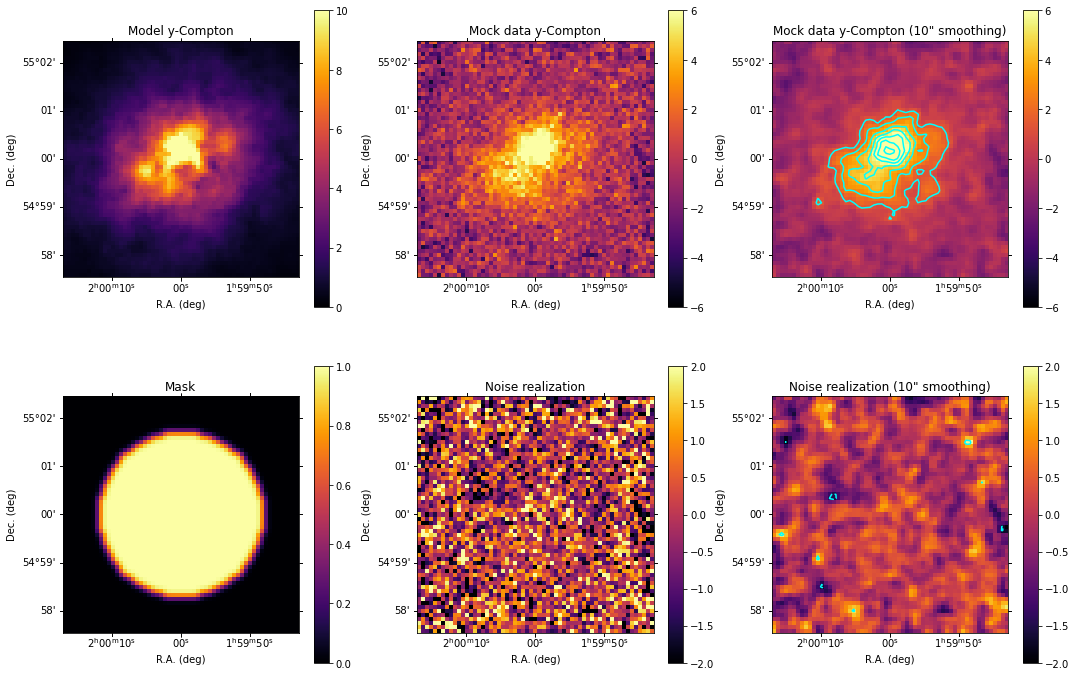

In [7]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='inferno', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='inferno',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='inferno', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='cyan')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='inferno', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(noise_mc[0]*1e5, cmap='inferno', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='inferno', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='cyan')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build the model to be used for the fit

In [8]:
model = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True)

model.set_pressure_profile_universal_param('A10MD')

model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}

model.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                     'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
        
model.map_header = data.header
model.los_reso  = los_reso
model.los_size  = los_size
model.R_truncation = model.R500*5

In [9]:
inference = pitszi.Inference(data, model)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.mcmc_nwalkers       = nwalkers
inference.mcmc_nsteps         = nsteps
inference.mcmc_burnin         = burnin
inference.mcmc_reset          = mcmc_reset
inference.mcmc_run            = mcmc_run
inference.mcmc_output_profile = mcmc_output_profile

inference.method_pk2d_extraction   = pk_method
inference.method_fluctuation_image = img_method

# Fit the spherical model

In [10]:
# ymap from mock
modeltrue_ymap_sph_deconv = mock.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm)    
modeltrue_ymap_sph        = mock.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm, irfs_convolution_TF=data.transfer_function) 

# ymap from fit
model_ymap_sph_deconv = inference.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm)    
model_ymap_sph        = inference.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm, irfs_convolution_TF=data.transfer_function) 

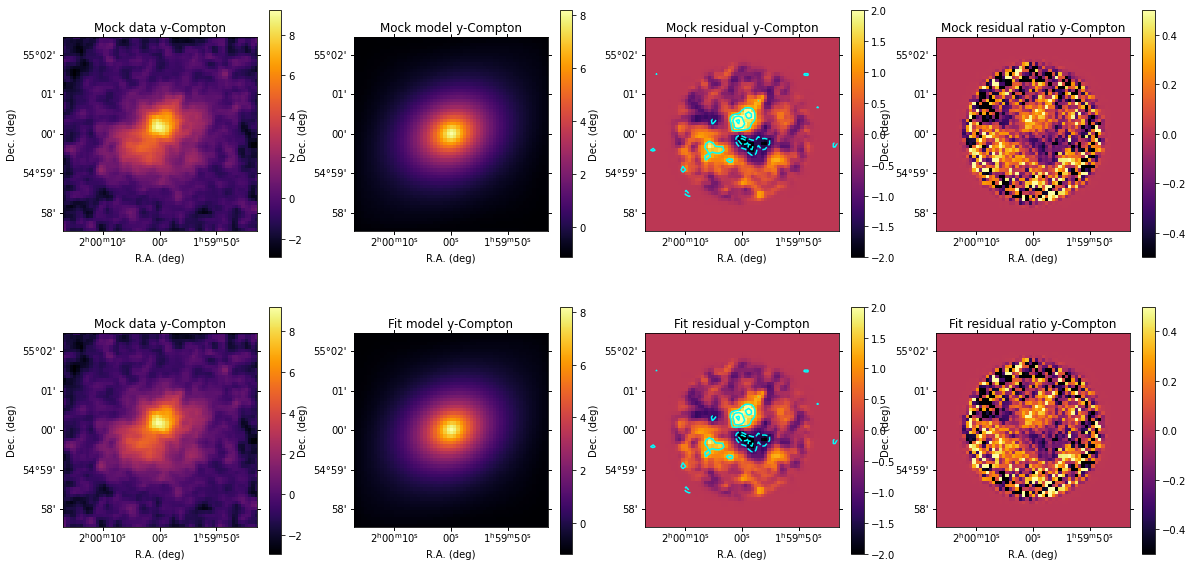

In [11]:
visu_smooth = 10

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(20, 10))

#----- Expected true smooth model
ax = plt.subplot(2, 4, 1, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='inferno')
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 2, projection=WCS(data.header))
plt.imshow(modeltrue_ymap_sph*1e5, cmap='inferno')
cb = plt.colorbar()
plt.title('Mock model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image - modeltrue_ymap_sph, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5*mask, cmap='inferno', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image - modeltrue_ymap_sph, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-13,-11,-9,-7,-5,-3,3,5,7,9,11,13], colors='cyan')
plt.title('Mock residual y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 4, projection=WCS(data.header))
plt.imshow((data.image - modeltrue_ymap_sph)/modeltrue_ymap_sph_deconv*mask, cmap='inferno', vmin=-0.5, vmax=0.5)
cb = plt.colorbar()
plt.title('Mock residual ratio y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Fitted smooth model
ax = plt.subplot(2, 4, 5, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='inferno')
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 6, projection=WCS(data.header))
plt.imshow(model_ymap_sph*1e5, cmap='inferno')
cb = plt.colorbar()
plt.title('Fit model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 7, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image - model_ymap_sph, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5*mask, cmap='inferno', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image - model_ymap_sph, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-13,-11,-9,-7,-5,-3,3,5,7,9,11,13], colors='cyan')
plt.title('Fit residual y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 4, 8, projection=WCS(data.header))
plt.imshow((data.image - model_ymap_sph)/model_ymap_sph_deconv*mask, cmap='inferno', vmin=-0.5, vmax=0.5)
cb = plt.colorbar()
plt.title('Fit residual ratio y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Fit the fluctuation parameters

In [12]:
data_ymap = data.image

In [13]:
#----- Compute the power spectrum from the data
if img_method == 'ratio':
    image = (data_ymap - model_ymap_sph)/model_ymap_sph_deconv
if img_method == 'subtract':
    image = data_ymap - model_ymap_sph
image *= mask
k, pk2d = pitszi.utils.get_pk2d(image, model.get_map_reso().to_value('arcsec'), 
                                Nbin=Nbins_pk, 
                                kmin=kmin_pk.to_value('arcsec-1'), kmax=kmax_pk.to_value('arcsec-1'))

In [14]:
#========== Compute the pk model
def pkmodel(par, test_cluster, 
            beam_FWHM, TF, mask,
            model_ymap_sph, model_ymap_sph_deconv, 
            Nbin, kmin, kmax):
    
    test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                               'Norm': par[0], 
                                               'slope': par[1],
                                               'Linj': par[2]*u.kpc,
                                               'Ldis': 1*u.kpc}

    test_ymap = test_cluster.get_sz_map(seed=None, no_fluctuations=False)
    test_ymap = pitszi.utils.apply_transfer_function(test_ymap, test_cluster.get_map_reso().to_value('arcsec'),
                                                     beam_FWHM.to_value('arcsec'), TF, 
                                                     apps_TF_LS=True, apps_beam=True)
    
    if img_method == 'ratio':
        test_image = (test_ymap - model_ymap_sph)/model_ymap_sph_deconv
    if img_method == 'subtract':
        test_image = test_ymap - model_ymap_sph
    
    test_image *= mask

    test_pk = pitszi.utils.get_pk2d(test_image, test_cluster.get_map_reso().to_value('arcsec'), 
                                    Nbin=Nbin, kmin=kmin, kmax=kmax)[1]

    return test_pk

#========== Log likelihood function
def lnlike(par, pk_data, pk_noise_exp, pk_error, pk_model_std, test_cluster,
           model_ymap_sph, model_ymap_sph_deconv,
           beam_FWHM, TF, mask, Nbin, kmin, kmax):
            
    # Prior
    if par[0] < 0: return -np.inf
    if par[0] > 2: return -np.inf
    if par[1] < 0: return -np.inf
    if par[1] > 5: return -np.inf
    if par[2] <= -11/3 - 2: return -np.inf
    if par[2] >= -11/3 + 2: return -np.inf
    if par[3] <= 100: return -np.inf
    if par[3] >= 10000: return -np.inf
    
    # model
    test_pk = pkmodel([par[1], par[2], par[3]], test_cluster, beam_FWHM, TF, mask, model_ymap_sph, model_ymap_sph_deconv, 
                      Nbin, kmin, kmax)
            
    # Add the noise
    test_pk += par[0] * pk_noise_exp

    # log likelihood
    lnL = -0.5*np.nansum((pk_data - test_pk)**2 / (pk_error**2 + pk_model_std**2))

    return lnL

In [15]:
#----- Get the error bars for the true underlying model
Nmc = 1000
pk_model_mc = np.zeros((Nmc, len(pk2d)))
for imc in range(Nmc):
    pk_model_mc[imc,:] = pkmodel([fluct_norm, fluct_slope, fluct_linj.to_value('kpc')], 
                           model, beam_FWHM, TF, mask, model_ymap_sph, model_ymap_sph_deconv, 
                           Nbins_pk, kmin_pk.to_value('arcsec-1'), kmax_pk.to_value('arcsec-1'))
pk_model_std = np.std(pk_model_mc, axis=0)
pk_model_mean = np.mean(pk_model_mc, axis=0)
print('--- Expected S/N for the stochastic model uncertainty')
print(pk_model_mean/pk_model_std)

--- Expected S/N for the stochastic model uncertainty
[1.2100917  1.24757517 1.32757512 1.56564639 1.40839342 1.72429414
 1.66236899 1.4338876  2.17779818 2.00422255 2.35369783 1.97349534
 1.90764561 2.12910042 2.1319625  2.20657773 2.61410259 2.47506419
 2.62953852 2.5607245  2.50725589 2.77697072 1.96181492 3.1703481
 2.63775367 2.65922532 2.77078648 3.01214052 2.90762359 3.15074405
 2.63808016 3.10259596 3.1659383  2.67089336 3.13204814 2.53918237
 3.36143403 3.05892934 3.25410645 3.07325057]


In [16]:
# Get the error bars and bias for the true noise
pk_noise_mc = np.zeros((noise_mc.shape[0], len(pk2d)))
for imc in range(noise_mc.shape[0]):    
    if img_method == 'ratio':
        image_noise_mc = (noise_mc[imc,:,:])/model_ymap_sph_deconv
    if img_method == 'subtract':
        image_noise_mc = noise_mc[imc,:,:]
    image_noise_mc *= mask
    pk2d_mc = pitszi.utils.get_pk2d(image_noise_mc, model.get_map_reso().to_value('arcsec'), 
                                Nbin=Nbins_pk, 
                                kmin=kmin_pk.to_value('arcsec-1'), kmax=kmax_pk.to_value('arcsec-1'))[1]
    pk_noise_mc[imc,:] = pk2d_mc
    
pk_noise_std = np.std(pk_noise_mc, axis=0)
pk_noise_mean = np.mean(pk_noise_mc, axis=0)
print('--- Expected S/N for the noise uncertainty')
print(pk_model_mean/pk_noise_std)

--- Expected S/N for the noise uncertainty
[1.55269556e+00 2.87898862e+00 6.05449925e+00 9.89958153e+00
 8.10242941e+00 1.23340114e+01 9.78371079e+00 5.70983390e+00
 8.86551063e+00 6.11328013e+00 6.00105583e+00 3.37592284e+00
 3.15977854e+00 2.58191376e+00 2.10380552e+00 1.38543768e+00
 1.33169754e+00 9.12217115e-01 8.03891585e-01 5.39387328e-01
 3.62076623e-01 3.32596372e-01 1.78647200e-01 2.41713157e-01
 1.17772573e-01 1.06647740e-01 8.78461212e-02 6.87301734e-02
 4.09151658e-02 3.69757338e-02 2.21126412e-02 2.10657256e-02
 1.68302715e-02 1.04427224e-02 1.03414998e-02 5.12898777e-03
 6.29094089e-03 3.91568613e-03 3.62519411e-03 3.13756096e-03]


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


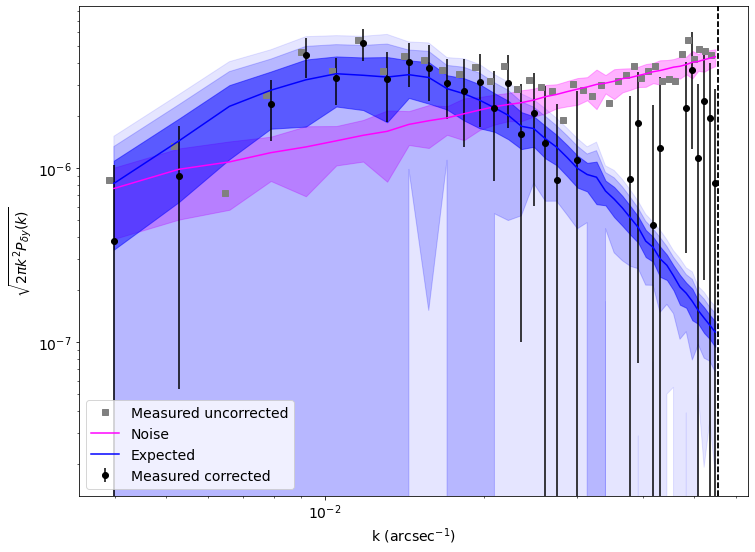

In [17]:
#----- Show the data before fitting
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(12, 9))
# Data
plt.plot(k*0.98, np.sqrt(2*np.pi*k**2*(pk2d)), color='grey', marker='s', ls='', label='Measured uncorrected')
plt.errorbar(k, np.sqrt(2*np.pi*k**2*(pk2d - pk_noise_mean)), np.sqrt(2*np.pi*k**2*(pk_noise_std)), color='k', ecolor='k', marker='o', ls='', label='Measured corrected')

# Noise
plt.plot(k, np.sqrt(2*np.pi*k**2*(pk_noise_mean)), color='magenta', label='Noise')
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk_noise_mean+pk_noise_std)), np.sqrt(2*np.pi*k**2*(pk_noise_mean-pk_noise_std)), color='magenta', alpha=0.3)

# True model expectation
plt.plot(k, np.sqrt(2*np.pi*k**2*(pk_model_mean)), color='blue', label='Expected')
up, low = pk_model_mean+pk_model_std, pk_model_mean-pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(up)), y2=np.sqrt(2*np.pi*k**2*(low)), color='blue', alpha=0.5)
up, low = pk_model_mean+2*pk_model_std, pk_model_mean-2*pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(low)), y2=np.sqrt(2*np.pi*k**2*(up)), color='blue', alpha=0.2)
up, low = pk_model_mean+3*pk_model_std, pk_model_mean-3*pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(low)), y2=np.sqrt(2*np.pi*k**2*(up)), color='blue', alpha=0.1)

# Recovered model
plt.axvline(1/beam_FWHM.to_value('arcsec'), color='k', ls='--')
plt.xlabel('k (arcsec$^{-1}$)')
if img_method == 'ratio':
    plt.ylabel(r'$\sqrt{2 \pi k^2 P_{\delta y / y}(k)}$')
if img_method == 'subtract':
    plt.ylabel(r'$\sqrt{2 \pi k^2 P_{\delta y}(k)}$')
plt.axvline(1/beam_FWHM.to_value('arcsec'), color='k', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [18]:
par_list = np.array(['Noise','Norm','alpha','Linj'])
par0 = np.array([1, fluct_norm, fluct_slope, fluct_linj.to_value('kpc')])
par_min = [0, 0,           fluct_slope-0.5, fluct_linj.to_value('kpc')/5]
par_max = [2, fluct_norm*5,fluct_slope+0.5, fluct_linj.to_value('kpc')*5]
pos = pitszi.utils.emcee_starting_point(par0, 0.1, par_min, par_max, nwalkers)
ndim = len(par_list)

sampler_file='/Users/adam/Desktop/sampler.h5'
backend = emcee.backends.HDFBackend(sampler_file)
backend.reset(nwalkers, ndim)
#moves = emcee.moves.StretchMove(a=2)    #--> 
#moves = emcee.moves.StretchMove(a=10.0)   #--> [50.61927666 51.21775275 52.62018415]
#moves = emcee.moves.WalkMove()            #--> [37.75371672 40.61195719 39.46655595]
moves = emcee.moves.KDEMove()             #--> tau: [25.95264354 28.29827061 27.13650034]
#cov = np.array([[4.66568304e-03, 2.26448646e-02, 9.34390150e+00],
#                [2.26448646e-02, 1.47478476e-01, 5.03307290e+01],
#                [9.34390150e+00, 5.03307290e+01, 2.61606874e+04]])
#moves = emcee.moves.GaussianMove(cov)             #--> 

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                    args=[pk2d, pk_noise_mean, pk_noise_std, pk_model_std, 
                                          model,
                                          model_ymap_sph, model_ymap_sph_deconv,
                                          beam_FWHM, TF, mask,
                                          Nbins_pk, kmin_pk.to_value('arcsec-1'), kmax_pk.to_value('arcsec-1')], 
                                    pool=Pool(cpu_count()), moves=moves, backend=backend)

res = sampler.run_mcmc(pos, nsteps, progress=True, store=True)

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


In [ ]:
for ic in range(sampler.chain.shape[2]):
    plt.figure(ic)
    plt.plot(sampler.chain[:,:,ic].T)
    plt.ylabel(par_list[ic])
    print(np.std(sampler.chain[:,:,ic].T))

In [ ]:
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
lnL_flat = lnL_chains.reshape(lnL_chains.shape[0]*lnL_chains.shape[1])

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(12, 9))
# Data
plt.errorbar(k, np.sqrt(2*np.pi*k**2*(pk2d)), np.sqrt(2*np.pi*k**2*(pk_noise_std**2+pk_model_std**2)**0.5), color='grey', ecolor='grey', marker='o', ls='', label='Measured')
plt.errorbar(k, np.sqrt(2*np.pi*k**2*(pk2d)), np.sqrt(2*np.pi*k**2*pk_noise_std), color='k', ecolor='k', marker='o', ls='')

# True model expectation
plt.plot(k, np.sqrt(2*np.pi*k**2*(pk_model_mean)), color='blue', label='Expected')
up, low = pk_model_mean+pk_model_std, pk_model_mean-pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(up)), y2=np.sqrt(2*np.pi*k**2*(low)), color='blue', alpha=0.5)
up, low = pk_model_mean+2*pk_model_std, pk_model_mean-2*pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(up)), y2=np.sqrt(2*np.pi*k**2*(low)), color='blue', alpha=0.2)
up, low = pk_model_mean+3*pk_model_std, pk_model_mean-3*pk_model_std
low[low<=0] = 0
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(up)), y2=np.sqrt(2*np.pi*k**2*(low)), color='blue', alpha=0.1)

# Recovered model
pk_mc_test = np.zeros((100, len(k)))
pk_mcn_test = np.zeros((100, len(k)))
for i in range(100):
    itest = int(np.random.uniform(0,par_flat.shape[0]-1))
    pk_test = pkmodel(par_flat[itest,1:4], model, 
                      beam_FWHM, TF, mask,
                      model_ymap_sph, model_ymap_sph_deconv, 
                      Nbins_pk, kmin_pk.to_value('arcsec-1'), kmax_pk.to_value('arcsec-1'))
    pk_mc_test[i, :]  = pk_test
    pk_mcn_test[i, :] = pk_noise_mean * par_flat[itest,0]
    plt.loglog(k, np.sqrt(2*np.pi*k**2*pk_test), alpha=0.1, color='r')
    plt.loglog(k, np.sqrt(2*np.pi*k**2*pk_mcn_test[i, :]), alpha=0.1, color='magenta')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mc_test,axis=0))), color='r', label='Recovered')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mc_test,axis=0)+np.std(pk_mc_test,axis=0))), ls='--', color='r')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mc_test,axis=0)-np.std(pk_mc_test,axis=0))), ls='--',  color='r')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mcn_test,axis=0))), color='magenta', label='Recovered')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mcn_test,axis=0)+np.std(pk_mcn_test,axis=0))), ls='--', color='magenta')
plt.plot(k, np.sqrt(2*np.pi*k**2*(np.mean(pk_mcn_test,axis=0)-np.std(pk_mcn_test,axis=0))), ls='--',  color='magenta')

plt.axvline(1/beam_FWHM.to_value('arcsec'), color='k', ls='--')
plt.xlabel('k (arcsec$^{-1}$)')
if img_method == 'ratio':
    plt.ylabel(r'$\sqrt{2 \pi k^2 P_{\delta y / y}(k)}$')
if img_method == 'subtract':
    plt.ylabel(r'$\sqrt{2 \pi k^2 P_{\delta y}(k)}$')
#plt.ylim(1e-3,1)
plt.legend()

In [ ]:

fig = plt.figure(1, figsize=(10,10))
fig = corner.corner(par_flat, bins=30, color='k', smooth=1,
                    labels=par_list, quantiles=(0.16, 0.84), fig=fig)

values = [1, fluct_norm, fluct_slope, fluct_linj.to_value('kpc')]
lims = [[0.9,1.1], [0.2,0.7], [-6,-2], [0,1200]]
axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(values[xi], color="r")
        ax.axhline(values[yi], color="r")
        ax.plot(values[xi], values[yi], "sr")
        #ax.set_xlim(lims[xi])
        #ax.set_ylim(lims[yi])
ax.set_title(img_method+' - '+pk_method+' - '+str(Nbins_pk)+' bins - '+str(kmin_pk)+':'+str(kmax_pk))

In [ ]:
cov = np.cov(par_flat, rowvar=False)
cov

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(12, 9))
# Input model
k3d_input, pk3d_input = mock.get_pressure_fluctuation_spectrum()
plt.plot(k3d_input.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_input.to_value('kpc-1')**3*pk3d_input.to_value('kpc3')), color='blue', lw=3, label='Input')

pk_mc_test = np.zeros((100, len(k3d_input)))
for i in range(100):
    itest = int(np.random.uniform(0,par_flat.shape[0]-1))
    model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'Norm': par_flat[itest,1], 
                                        'slope': par_flat[itest,2],
                                        'Linj': par_flat[itest,3]*u.kpc,
                                        'Ldis': 1*u.kpc}

    pk_mc_test[i, :] = model.get_pressure_fluctuation_spectrum()[1].to_value('kpc3')
    plt.loglog(k3d_input.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_input.to_value('kpc-1')**3*pk_mc_test[i, :]), alpha=0.1, color='r')
    
plt.plot(k3d_input.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_input.to_value('kpc-1')**3*(np.mean(pk_mc_test,axis=0))), color='r', lw=3, label='Recovered')
plt.plot(k3d_input.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_input.to_value('kpc-1')**3*(np.mean(pk_mc_test,axis=0)+np.std(pk_mc_test,axis=0))), ls='--', lw=3, color='r')
plt.plot(k3d_input.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_input.to_value('kpc-1')**3*(np.mean(pk_mc_test,axis=0)-np.std(pk_mc_test,axis=0))), ls='--', lw=3, color='r')

plt.xlabel('k (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P_{\delta P / P}(k)}$')
plt.ylim(1e-2,1)
plt.xlim(5e-4,1e-1)
plt.legend()